# Session 10 Gaussian Processes

### Introduction
- Interested in predicting the function at concrete points
- Bayesian inference: Update the current hypothesis as new information becomes available
- Choice of kernel (covariance function) is crucial for the shape of the prior and posterior of the GP

**Gaussian Processes**

- Using conditioning we can find the probabilities from the joint distribution

### Problem 1: Proof that scalar multiplication/quadratic of a linear kernel is still a kernel

Consider the scalar $c$ and the linear kernel k(x,x'). We then have

$$ k_1(x,x') = c k(x,x') $$

Given that kernels can be represented by positive, semi-definite matrices, that k is also a kernel.

**Positive Semi-Definite**: A symmetric matrix is said to be *positive semi-definite* iff the associated quadratic form q is non-negative everywhere. Eigenvalues of A are non-negative 

**Symmetric**: a square matrix that is equal to the transpose 

**Feature Map**: the output activations for a given filter. It is a mapping that corresponds to the activation of different parts of an image. Since a kernel function corresponds to an inner product in some (possibly infinite dimensional) feature space, we can also write the kernel as a feature mapping.

When using a Kernel in a linear model, it is just like transforming the input data

$k_1(x,x')$ is symmetric and positive semidefinite. \Proof: if $\phi$ is the feature map for $\kappa$, $\sqrt{\gamma}\phi$ is a valid feature map for $\gamma \kappa$.

If $\kappa$ is a pd kernel and 
$ f: \chi \rightarrow \mathbb{R},\ 
g(x,y) := f(x)\kappa f(y)$
is as well.\
Proof: Use the feature map $x \rightarrow f(x)\phi(x)$


### Problem 2: Compute the posterior of a Gaussian process

- Kernel is the subspace of the domain -> can have many bases
- Kernel is the set of all points defined by the dot product of the two vectors


https://stats.stackexchange.com/questions/182805/proof-that-the-linear-kernel-is-a-kernel-understanding-the-math

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd

### Problem 3: Sampling from a GP prior

In [4]:
!pip install gpflow

In [10]:
import gpflow
import sklearn.gaussian_process.kernels

#### Covariance Functions:
I define two covariance functions to test. The first is the normal definition of the covariance. The second is the 'squared exponential' covariance function. The squared exponential is a simple stationary parametric covariance function with a smooth sample path. This is also known as the **RBF Kernel**. Other covariance functions include Matern covariance and rational quadratic.

In [11]:
def covariance(x,y):
    # finding the mean of the series x and y
    mean_x = sum(x)/float(len(x))
    mean_y = sum(y)/float(len(x))
    # subtracting mean from the individual elements
    sub_x = [i-mean_x for i in x]
    sub_y = [i-mean_y for i in y]
    numerator = sum([sub_x[i]*sub_y[i] for i in range(len(sub_x))])
    denominator = len(x)-1
    cov = numerator/denominator
    return cov

In [12]:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)


In [13]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

<ErrorbarContainer object of 3 artists>

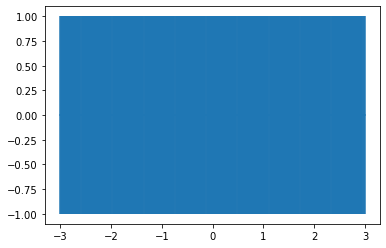

In [14]:
theta = [1, 10]
sigma_0 = exponential_cov(0, 0, theta)
# sigma_0 = covariance([0,1,2,3,4],[0,1,2,3,4])
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)

Note theta represents the hyperparameters. Selecting an arbitrary starting point: x = 1. 

In [69]:
x = [1.]
y = [np.random.normal(scale=sigma_0)]
print(y)

[-1.532689286020542]


Can update the confidence band given the point we just sampled using the covariance function to generate new point-wise intervals, conditional on the value x_0 and y_0

In [70]:
sigma_1 = exponential_cov(x,x, theta)

In [71]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, sigma_1, y) for i in x_pred]

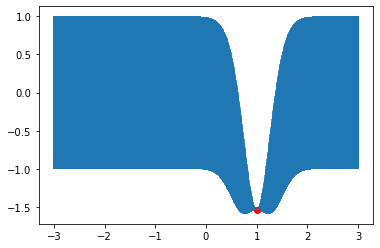

In [72]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr = sigmas, capsize = 0)
plt.plot(x, y, 'ro')

So conditional on this point and the covariance structure, we have essentially constrained the probable location of additional points

In [73]:
m, s = conditional([-0.7], x, y, theta)
y2 = np.random.normal(m, s)
print(y2)

-0.6963628236068277


This point is the added to the realization and can be used to further update the location of the next point

In [74]:
x.append(-0.7)
y.append(y2)
sigma_2 = exponential_cov(x, x, theta)
predictions =  [predict(i, x, exponential_cov, theta, sigma_2, y) for i in x_pred]

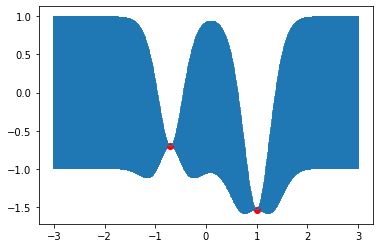

In [75]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr = sigmas, capsize = 0)
plt.plot(x, y, 'ro')

Sample several points at once:

In [76]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, theta)
y_more = np.random.multivariate_normal(mu, s)
print(y_more)

[ 0.68664784  0.64164187 -0.51974934 -1.10996198 -1.2111731 ]


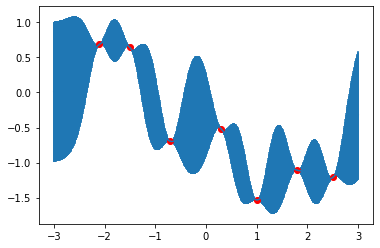

In [77]:
x += x_more
y += y_more.tolist()
sigma_new = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, sigma_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

### Different Covariance functions:
In order to change the covariance, we have to look more closely at the kernel function. We will start with the Matern covariance.

In [52]:
import sklearn
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel


In [79]:
kernel = LinearKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

NameError: name 'LinearKernel' is not defined

In [54]:
print(x)

[1.0, -0.7, -2.1, -1.5, 0.3, 1.8, 2.5]


In [55]:
x_new = np.array(x)

X = x_new.reshape(-1, 1)
print(X.shape)

(7, 1)


In [58]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

/Users/Ivan/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1))

In [59]:
gp.kernel_

0.249**2 + Matern(length_scale=1.26, nu=1.5) + WhiteKernel(noise_level=1e-05)

Here we can see the exact kernel used to parameterize the GP, along with their corresponding optimal hyperparameter values.

We can also give a prediction method. For a Gaussian Process, this is done through the posterior predictive distribution, which is the GP with the mean and covariance functions updated to their posterior forms

$$ p(y^*|y, x, x^*) = GP(m^*(x^*), k^*(x^*))$$

where the posterior mean and covariance functions are calculated as:
$$ m^*(x^*) = k(x^*, x)^T[k(x,x) + \sigma^2I]^{-1}y$$
$$k^*(x^*) = k(x^*,x^*)+\sigma^2-k(x^*,x)^T[k(x,x)+\sigma^2I]^{-1}k(x^*,x) $$

In [60]:
x_pred = np.linspace(-6,6).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

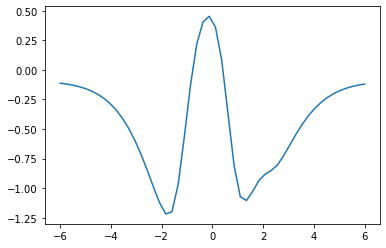

In [63]:
plt.plot(x_pred, y_pred)

### Problem 4: Forecasting 30 days of new cases of Covid in portugal

In [8]:
import gpflow

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from numpy.linalg import inv
from numpy.linalg import det
from scipy.optimize import minimize

pd.options.mode.chained_assignment = None

In [8]:
def multivariate_normal(x, d, mean, covariance):
    return (1. / (np.sqrt((2*np.pi)**d * np.linalg.det(covariance))) 
            * np.exp(-(np.linalg.solve(covariance, x-mean).T.dot(x-mean))/2))

In [9]:
def calculate_pdf(mean, covariance, d):
    x_ = 100
    xs = np.linspace(-5, 5, x_)
    ys = np.linspace(-5, 5, x_)
    x, y = np.meshgrid(xs, ys)
    pdf = np.zeros((x_, x_))
    for i in range(x_):
        for j in range(x_):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x[i,j]], [y[i,j]]]), 
                d, mean, covariance)
    return x, y, pdf

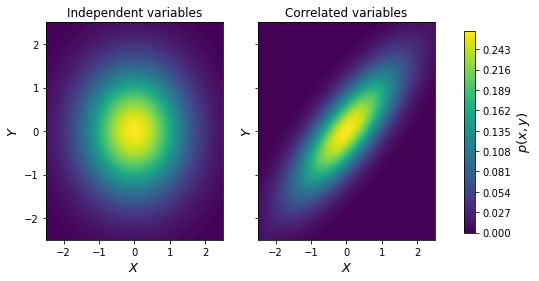

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True)
d = 2 

mean_ind = np.matrix([[0.], [0.]])
covariance_ind = np.matrix([
    [1., 0.], 
    [0., 1.]])
x, y, p = calculate_pdf(
    mean_ind, covariance_ind, d)

ax[0].contourf(x, y, p, 100)
ax[0].set_xlabel('$X$', fontsize=13)
ax[0].set_ylabel('$Y$', fontsize=13)
ax[0].axis([-2.5, 2.5, -2.5, 2.5])

mean_corr = np.matrix([[0.], [0.]])
covariance_corr = np.matrix([
    [1., 0.8], 
    [0.8, 1.]])
x, y, p = calculate_pdf(
    mean_corr, covariance_corr, d)

con = ax[1].contourf(x, y, p, 100)
ax[1].set_xlabel('$X$', fontsize=13)
ax[1].set_ylabel('$Y$', fontsize=13)
ax[1].axis([-2.5, 2.5, -2.5, 2.5])

ax[0].set_title('Independent variables', fontsize=12)
ax[1].set_title('Correlated variables', fontsize=12)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x, y)$', fontsize=13)
plt.show()

Correlated variables carry a ellipse shape to covariance matrix

### Problem 11: Function simulation

In [36]:
!pip install scikit-neuralnetwork

  Preparing metadata (setup.py) ... done
  Using cached Theano-1.0.5-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-neuralnetwork: filename=scikit_neuralnetwork-0.7-py3-none-any.whl size=41698 sha256=0fdde410e85a0d261bf736f41ad5239baa7fae607e2cd78d312cb479b0872814
  Stored in directory: /Users/Ivan/Library/Caches/pip/wheels/21/a8/91/3ba50335c55ec89bf4197510be97b76a31fb6ea7c4da5e6352
  Created wheel for Lasagne: filename=Lasagne-0.1-py3-none-any.whl size=79283 sha256=e71fab8ab2d70d3bbae6a8bfd0e06f3e8e89a4382bf33bc267e44e5b67f8e290
  Stored in directory: /Users/Ivan/Library/Caches/pip/wheels/de/c8/58/09985ed559ace44cd6874b5e5ec4973e24eb35b1c818f4db32
Successfully built scikit-neuralnetwork Lasagne


In [19]:
import random
import math

In [65]:
# Randomly sample from -1 to 1
x = np.random.uniform(-1, 1, size=50)

# Functions
square = x**2
sin = np.sin(x)
absolute = abs(x)
heaviside = np.heaviside(x, 0)

Training a two-layer network with 3 hidden units with 'tanh' activation functions and linear output units

In [61]:
from numpy import exp, array, random, dot, tanh

# Class to create a neural
# network with single neuron
class NeuralNetwork():
     
    def __init__(self):
         
        # Using seed to make sure it'll 
        # generate same weights in every run
        random.seed(1)
         
        # 3x1 Weight matrix
        self.weight_matrix = 2 * random.random((3, 1)) - 1
 
    # tanh as activation function
    def tanh(self, x):
        return tanh(x)
 
    # derivative of tanh function.
    # Needed to calculate the gradients.
    def tanh_derivative(self, x):
        return 1.0 - tanh(x) ** 2
 
    # forward propagation
    def forward_propagation(self, inputs):
        return self.tanh(dot(inputs, self.weight_matrix))
     
    # training the neural network.
    def train(self, train_inputs, train_outputs,
                            num_train_iterations):
                                 
        # Number of iterations we want to
        # perform for this set of input.
        for iteration in range(num_train_iterations):
            output = self.forward_propagation(train_inputs)
 
            # Calculate the error in the output.
            error = train_outputs - output
 
            # multiply the error by input and then
            # by gradient of tanh function to calculate
            # the adjustment needs to be made in weights
            adjustment = dot(train_inputs.T, error *
                             self.tanh_derivative(output))
                              
            # Adjust the weight matrix
            self.weight_matrix += adjustment


In [ ]:
# Driver Code
if __name__ == "__main__":
     
    neural_network = NeuralNetwork()
     
    print ('Random weights at the start of training')
    print (neural_network.weight_matrix)
    
    
 
    train_inputs = array([[0, 0, 1], [1, 1, 1], [1, 0, 1], [0, 1, 1]])
    train_outputs = array([[0, 1, 1, 0]]).T
 
    neural_network.train(train_inputs, train_outputs, 10000)
 
    print ('New weights after training')
    print (neural_network.weight_matrix)
 
    # Test the neural network with a new situation.
    print ("Testing network on new examples ->")
    print (neural_network.forward_propagation(array([1, 0, 0])))

### Problem 5: Online and Batch-Learning

How do ML models in production learn incrementally from the stream of incoming data? Key considerations are:\
**Volume**: preprocessing in order to make data available for both training and prediction \
**Velocity**: Data coming in at higher speeds (ex. tweets) can also be a key criteria \
**Variety**: Data aggregator services such as Uber and Airbnb

**Batch Learning**: The training of the models at regular intervals such as weekly, monthly, quaarterly, etc. Data is accumulated over a period of time.
- requires training the models with the entire training data set 
- Improving model requires re-training on entire training data set
- Business requirements do not require frequent learning of models
- data distribution is not expected to change frequently
- Not as complicated to use
- Error term is calculated in one go

**Online Learning**: Training happens in an incremental manner by continuously feeding data as it arrives or in a small group. Best for data that arrives in a continuous manner (stocks). Also good if you have limited computing resources
- Best for huge datasets that can not fit in one machine's main memory
- Key is in the *learning rate*
- If the system is fed with bad data, the system will have bad performance and the user will see the impact instantly
- Updating the average error term

Can make a difference with cross validation so using a mix of batch and online learning is most useful


### Scenario 2

In [54]:
from sklearn.model_selection import train_test_split # split the data into training and testing
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # creates support vector machine for classification
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import roc_curve, auc

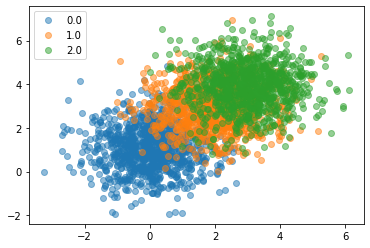

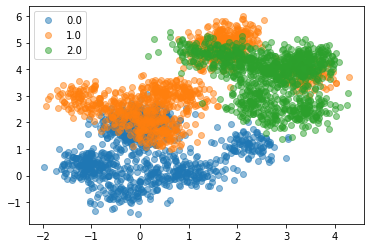

In [56]:
mu1 = [0,1]
mu2 = [2,3]
mu3 = [3,4]
n_data_points = 1000
plot_graphs = 1

np.random.seed(42)
xa = np.random.multivariate_normal(mu1, np.eye(2), n_data_points)
ya = np.zeros(n_data_points)

xb = np.random.multivariate_normal(mu2, np.eye(2), n_data_points)
yb = np.ones(n_data_points)

xc = np.random.multivariate_normal(mu3, np.eye(2), n_data_points)
yc = [yb+1 for yb in yb]

data_x = np.concatenate((xa, xb, xc))
data_y = np.concatenate((ya, yb, yc)).reshape(-1, 1)

data_scenario1 = pd.DataFrame(data=np.concatenate((data_x, data_y), 1), columns=['X1', 'X2', 'Y'])

groups = data_scenario1.groupby('Y')

if plot_graphs == 1:
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group['X1'], group['X2'], marker='o', linestyle='', alpha=.5, label=name)
    ax.legend(loc="upper left")
    plt.savefig("Scenario1.png")
    plt.show()
    
##################################################

n_groups = 10
X2 = np.empty((0, 2))
mean_all = np.random.multivariate_normal(mu1, np.eye(2), n_groups)
for mu in mean_all:
    X2 = np.vstack(
        [X2, np.random.multivariate_normal(mu, 0.1 * np.eye(2), int(round(n_data_points / 10)))])

mean_all = np.random.multivariate_normal(mu2, np.eye(2), n_groups)
for mu in mean_all:
    X2 = np.vstack(
        [X2, np.random.multivariate_normal(mu, 0.1 * np.eye(2), int(round(n_data_points / 10)))])

mean_all = np.random.multivariate_normal(mu3, np.eye(2), n_groups)
for mu in mean_all:
    X2 = np.vstack(
        [X2, np.random.multivariate_normal(mu, 0.1 * np.eye(2), int(round(n_data_points / 10)))])
    
data_scenario2 = pd.DataFrame(data=np.concatenate((X2, data_y), 1), columns=['X1', 'X2', 'Y'])

groups = data_scenario2.groupby('Y')

if plot_graphs == 1:
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group['X1'], group['X2'], marker='o', linestyle='', alpha=.5, label=name)
    ax.legend(loc="upper left")
    plt.savefig("Scenario2.png")
    plt.show()

In [57]:
data_scenario2.head()

,X1,X2,Y
0,-1.035198,0.495316,0.0
1,-0.325984,0.282068,0.0
2,-1.214566,0.405935,0.0
3,-0.775238,-0.107339,0.0
4,-1.735645,0.183407,0.0


In [58]:
X = data_scenario2.drop('Y', axis=1).copy()
X.head()

,X1,X2
0,-1.035198,0.495316
1,-0.325984,0.282068
2,-1.214566,0.405935
3,-0.775238,-0.107339
4,-1.735645,0.183407


In [59]:
y = data_scenario2['Y'].copy()
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Y, dtype: float64

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

### Neural Network with MNIST

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [40]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels) , (test_images, test_labels) = mnist.load_data()

train_images shape:  (60000, 28, 28)
train_labels shape:  (60000,)
test_images shape:  (10000, 28, 28)
test_labels shape:  (10000,)


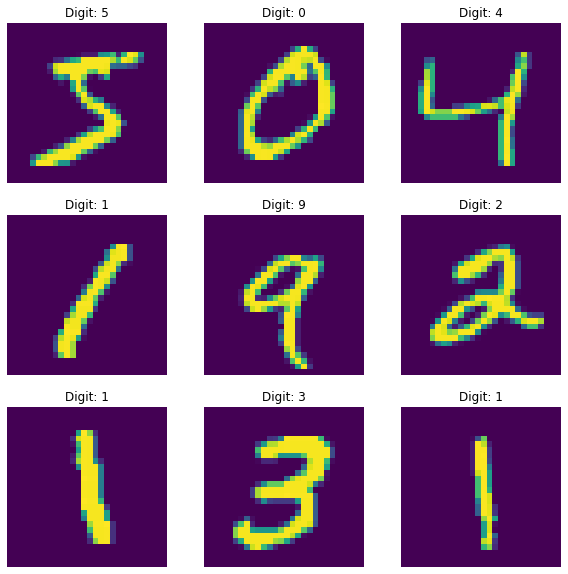

In [41]:
# Printing the shapes
print("train_images shape: ", train_images.shape)
print("train_labels shape: ", train_labels.shape)
print("test_images shape: ", test_images.shape)
print("test_labels shape: ", test_labels.shape)


# Displaying first 9 images of dataset

fig = plt.figure(figsize=(10,10))
 
nrows=3
ncols=3
for i in range(9):
    fig.add_subplot(nrows, ncols, i+1)
    plt.imshow(train_images[i])
    plt.title("Digit: {}".format(train_labels[i]))
    plt.axis(False)
    
plt.show()

#### Preprocessing the Data

- Normalize the grayscale pixels
- Change labels from digits to one-hot encoded vectors (all elements are 0 except index. Similar to dummy)

In [42]:
# Converting image pixel values to 0 - 1
train_images = train_images / 255
test_images = test_images / 255
 
print("First Label before conversion:")
print(train_labels[0])
 
# Converting labels to one-hot encoded vectors
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)
 
print("First Label after conversion:")
print(train_labels[0])

First Label before conversion:
5
First Label after conversion:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


#### Setting up the Layers:
- Flatten Layer to convert 2D arrays of 28x28 pixels into a 1D array of 784 pixels
- Hidden Layer with 512 relu activation function
- Output Layer with 10 output neurons which outputs probabilities for each digit

In [43]:
# Using Sequential() to build layers one after another
model = tf.keras.Sequential([
   
  # Flatten Layer that converts images to 1D array
  tf.keras.layers.Flatten(),
   
  # Hidden Layer with 512 units and relu activation
  tf.keras.layers.Dense(units=512, activation='relu'),
   
  # Output Layer with 10 units for 10 classes and softmax activation
  tf.keras.layers.Dense(units=10, activation='softmax')
])

2022-05-18 15:50:20.867649: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Compiling the model:
We need 3 attributes to give to the model during the models compile step:
- Loss Function to minimize
- Optimizer to update weights/parameters by looking at data and loss function
- Metrics used to monitor the train and test steps

In [44]:
model.compile(
  loss = 'categorical_crossentropy',
  optimizer = 'adam',
  metrics = ['accuracy']
)

#### Training the Neural Network
We again need 3 things:
- Training data from train_images
- Training Labels which represent output of training images
- Epochs which is the number of times our model will iterate on all training examples

In [45]:
history = model.fit(x = train_images, y = train_labels, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2004 - accuracy: 0.9416
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0788 - accuracy: 0.9766
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0521 - accuracy: 0.9839
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0366 - accuracy: 0.9883
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0269 - accuracy: 0.9912
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0201 - accuracy: 0.9931
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0175 - accuracy: 0.9942
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0142 - accuracy: 0.9952
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0109 - accuracy: 0.9964
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0

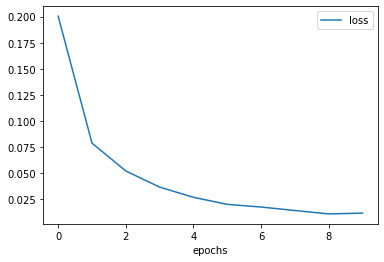

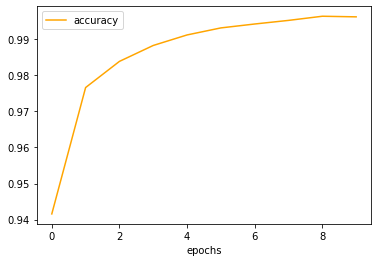

In [46]:
# Showing plot for loss
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.legend(['loss'])
plt.show()
 
# Showing plot for accuracy
plt.plot(history.history['accuracy'], color='orange')
plt.xlabel('epochs')
plt.legend(['accuracy'])
plt.show()

#### Evaluating the neural network
How does this perform on data our model hasn't seen before?

In [47]:
# Call evaluate to find the accuracy on test images
test_loss, test_accuracy = model.evaluate(
  x = test_images, 
  y = test_labels
)
 
print("Test Loss: %.4f"%test_loss)
print("Test Accuracy: %.4f"%test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.0960 - accuracy: 0.9783
Test Loss: 0.0960
Test Accuracy: 0.9783


We can also make predictions on new images and see what our model identifies in the image. Done in 2 steps:
- **Predicting Probabilities**: Returns the probability for an image of it belonging to one of the classes
- **Predicting Classes**: The class with maximum probability is the one predicted by the model

In [48]:
predicted_probabilities = model.predict(test_images)
predicted_classes = tf.argmax(predicted_probabilities, axis=-1).numpy()

Probabilities predicted for image at index 125
[5.9938200e-11 3.6315260e-08 7.0313154e-06 2.5526242e-07 5.1158760e-04
 5.9245014e-10 1.2623768e-13 3.0215261e-07 1.7590941e-07 9.9948066e-01]

Probabilities class for image at index 125
9


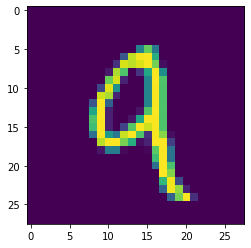

In [51]:
index=125
 
# Showing image
plt.imshow(test_images[index])
 
# Printing Probabilities
print("Probabilities predicted for image at index", index)
print(predicted_probabilities[index])
 
print()
 
# Printing Predicted Class
print("Probabilities class for image at index", index)
print(predicted_classes[index])